# Kernel Methods & Gaussian Processes: Learning Probability Distributions Over Functions

![Mauna Loa Observatory](https://dynamic-media-cdn.tripadvisor.com/media/photo-o/0f/5b/30/eb/photo1jpg.jpg?w=900&h=500&s=1)
*Mauna Loa Observatory, Hawaii - Home of the longest continuous CO₂ measurement record*

## Learning Objectives

By the end of this lecture, you will be able to:

1. **Understand the fundamental paradigm shift**: From learning single predictions to learning probability distributions over functions
2. **Master kernel engineering**: Design and combine kernels to encode domain knowledge about patterns in data
3. **Leverage small data effectively**: Apply GPs when neural networks fail due to limited training data
4. **Quantify uncertainty**: Obtain calibrated confidence intervals for predictions
5. **Think beyond formulas**: Design custom kernels using neural networks, simulations, or any similarity measure
6. **Make informed model choices**: Know when to use GPs vs neural networks for real-world problems

## Why This Matters

Neural networks dominate machine learning headlines, but they have a critical weakness: **they need massive amounts of data and provide no uncertainty estimates**. Gaussian Processes offer a fundamentally different approach that excels in scientific applications, safety-critical systems, and anywhere you have limited data but need reliable predictions with honest uncertainty.

Today, we'll use the iconic Mauna Loa CO₂ dataset to explore these concepts interactively.

In [1]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process.kernels import ExpSineSquared, Matern
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Styling for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

---
# Hook: The Small Data Miracle

## The Question That Changes Everything

Imagine you have only **10 irregularly-spaced measurements** of atmospheric CO₂ from 2010-2016. Can you:
- Fit the data accurately?
- Predict into 2017 (1+ year extrapolation)?
- Quantify your uncertainty?
- Match the ground truth pattern?

**Neural networks will fail spectacularly. Gaussian Processes will excel.**

Let's see this in action right now - we'll explain *why* afterwards.

In [2]:
# Load Mauna Loa CO2 data from local file
print("Loading real Mauna Loa CO₂ data for demonstration")
df = pd.read_csv('data/archive.csv', comment='#', header=0)
# Rename columns for consistency
df = df.rename(columns={'Decimal Date': 'decimal_date', 'Carbon Dioxide (ppm)': 'co2'})

# Remove rows with NaN values in CO2 measurements
df = df.dropna(subset=['co2'])

# Store full data (from 2010 onwards for more data points)
X_full = df[df['decimal_date'] >= 2010]['decimal_date'].values.reshape(-1, 1)
y_full = df[df['decimal_date'] >= 2010]['co2'].values

# EXTREME SPARSITY: Select only 10 irregularly-spaced points from real data!
# Irregular sampling makes the problem harder and more realistic
# Data available from 1958 to 2017, we sample from 2010-2015 only
# This creates a challenging extrapolation scenario to 2017
# Note: These are TARGET dates - we find the closest REAL measurements
sparse_dates = np.array([2010.2, 2010.9, 2011.6, 2012.3, 2012.8, 
                        2013.5, 2014.1, 2014.7, 2015.3, 2015.9])

# Find closest actual measurements to these dates
X_train = []
y_train = []
for target_date in sparse_dates:
    # Find closest date in real data
    idx = np.argmin(np.abs(X_full.ravel() - target_date))
    X_train.append(X_full[idx, 0])
    y_train.append(y_full[idx])

X_train = np.array(X_train).reshape(-1, 1)
y_train = np.array(y_train)

# MASSIVE extrapolation (to 2017 where we have ground truth)
X_test = np.linspace(2010, 2017.1, 500).reshape(-1, 1)

print(f"✓ Loaded {len(X_train)} irregularly-spaced training points from REAL CO₂ data")
print(f"✓ Training range: {X_train.min():.1f} to {X_train.max():.1f}")
print(f"✓ Sample CO₂ values: {y_train[:3]} ppm (actual measurements!)")
print(f"✓ Extrapolation: {X_train.max():.1f} → 2017.1 ({2017.1 - X_train.max():.1f} years!)")

Loading real Mauna Loa CO₂ data for demonstration
✓ Loaded 10 irregularly-spaced training points from REAL CO₂ data
✓ Training range: 2010.2 to 2015.9
✓ Sample CO₂ values: [391.01 388.67 390.21] ppm (actual measurements!)
✓ Extrapolation: 2015.9 → 2017.1 (1.2 years!)


✓ Optimized GP kernel: 3.38**2 * RBF(length_scale=10) + 1.14**2 * ExpSineSquared(length_scale=1.77, periodicity=1) + WhiteKernel(noise_level=0.001)
✓ NN trained with 3-layer architecture (200 neurons each)


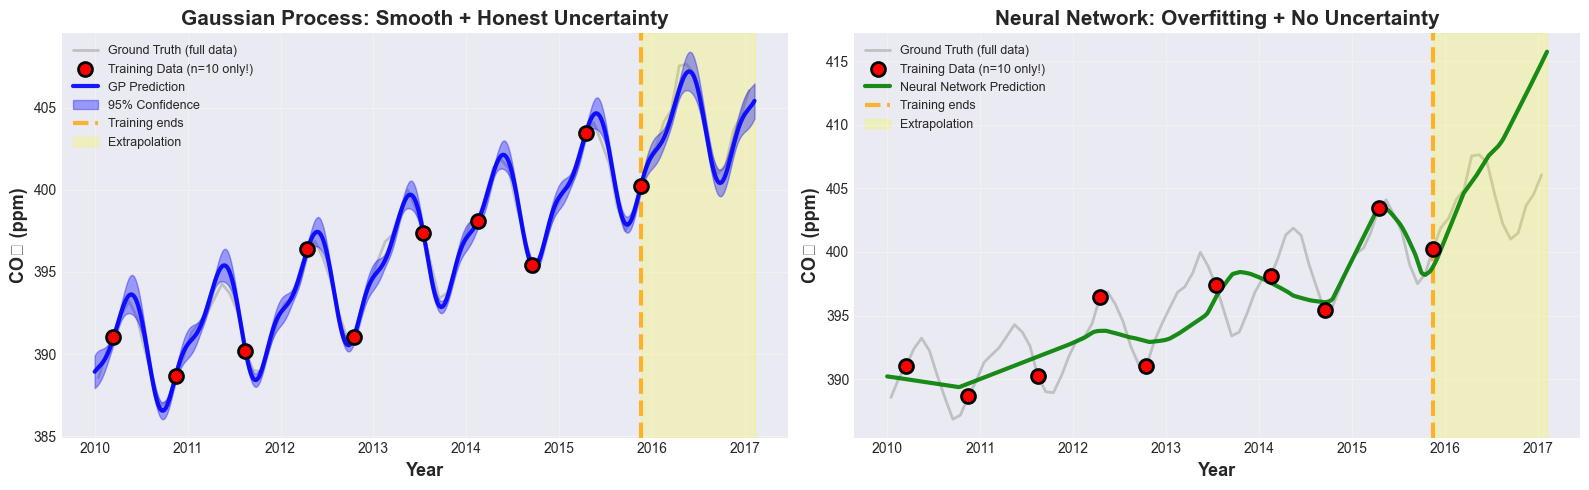


QUANTITATIVE COMPARISON:
Interpolation MSE (on held-out ground truth):
  GP:  0.247 ppm²
  NN:  5.448 ppm²
  Winner: GP (5.201 ppm² better)


In [3]:
# The Showdown: GP vs Neural Network on sparse data
# Compare how each model handles limited training data:
# - GP: Handles sparse data gracefully with honest uncertainty
# - NN: Tends to overfit with limited data and provides no uncertainty estimates

# Gaussian Process with composite kernel to capture CO2 patterns:
# - Long-term smooth trend (RBF with long length scale)
# - Annual seasonality (Periodic kernel with period=1 year, FIXED)
# - Noise (WhiteKernel)
from sklearn.gaussian_process.kernels import ExpSineSquared

# Composite kernel to capture CO2 patterns: Trend + Seasonality + Noise
# Additive structure allows each component to contribute independently
kernel_gp = (C(1.0, (1e-2, 1e2)) * RBF(length_scale=3.0, length_scale_bounds=(1, 10)) +  # Long-term trend
             C(1.0, (1e-2, 1e2)) * ExpSineSquared(length_scale=1.0, periodicity=1.0,  # Annual seasonality
                                                   length_scale_bounds=(0.1, 3.0),
                                                   periodicity_bounds="fixed") +  # Fix period to exactly 1 year
             WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-3, 1)))  # Noise

gp = GaussianProcessRegressor(kernel=kernel_gp, n_restarts_optimizer=10, normalize_y=True, alpha=1e-6)
gp.fit(X_train, y_train)
y_pred_gp, sigma_gp = gp.predict(X_test, return_std=True)

print(f"✓ Optimized GP kernel: {gp.kernel_}")

# Neural Network - Train with standard configuration
# We'll use a typical deep network architecture for comparison
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Train neural network with standard configuration
nn = MLPRegressor(hidden_layer_sizes=(200, 200, 200),
                  alpha=0.0,  # No regularization to show typical behavior on sparse data
                  early_stopping=False,
                  max_iter=20000,
                  learning_rate_init=0.05,
                  learning_rate='constant',
                  random_state=42,
                  verbose=False)

nn.fit(X_train_scaled, y_train_scaled)

X_test_scaled = scaler_X.transform(X_test)
y_pred_nn = scaler_y.inverse_transform(nn.predict(X_test_scaled).reshape(-1, 1)).ravel()

print(f"✓ NN trained with 3-layer architecture (200 neurons each)")

# Plot the comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot ground truth data (full dataset) in both plots for comparison
# This shows what the models SHOULD be learning
ground_truth_mask = (X_full.ravel() >= X_test.min()) & (X_full.ravel() <= X_test.max())
X_ground_truth = X_full[ground_truth_mask]
y_ground_truth = y_full[ground_truth_mask]

# GP Plot
ax1.plot(X_ground_truth, y_ground_truth, 'gray', lw=2, alpha=0.4, 
         label='Ground Truth (full data)', zorder=1)
ax1.scatter(X_train, y_train, c='red', s=100, zorder=10, edgecolor='k', linewidth=2, 
           label=f'Training Data (n={len(X_train)} only!)')
ax1.plot(X_test, y_pred_gp, 'b-', lw=3, label='GP Prediction', alpha=0.9, zorder=5)
ax1.fill_between(X_test.ravel(), 
                  y_pred_gp - 2*sigma_gp, 
                  y_pred_gp + 2*sigma_gp,
                  alpha=0.35, color='blue', label='95% Confidence', zorder=4)
ax1.axvline(x=X_train.max(), color='orange', linestyle='--', lw=3, alpha=0.8, label='Training ends')
ax1.axvspan(X_train.max(), X_test.max(), alpha=0.2, color='yellow', label='Extrapolation')
ax1.set_xlabel('Year', fontsize=13, fontweight='bold')
ax1.set_ylabel('CO₂ (ppm)', fontsize=13, fontweight='bold')
ax1.set_title('Gaussian Process: Smooth + Honest Uncertainty', fontsize=15, fontweight='bold')
ax1.legend(fontsize=9, loc='upper left')
ax1.grid(True, alpha=0.3)

# NN Plot
ax2.plot(X_ground_truth, y_ground_truth, 'gray', lw=2, alpha=0.4,
         label='Ground Truth (full data)', zorder=1)
ax2.scatter(X_train, y_train, c='red', s=100, zorder=10, edgecolor='k', linewidth=2,
           label=f'Training Data (n={len(X_train)} only!)')
ax2.plot(X_test, y_pred_nn, 'g-', lw=3, label='Neural Network Prediction', alpha=0.9, zorder=5)
ax2.axvline(x=X_train.max(), color='orange', linestyle='--', lw=3, alpha=0.8, label='Training ends')
ax2.axvspan(X_train.max(), X_test.max(), alpha=0.2, color='yellow', label='Extrapolation')
ax2.set_xlabel('Year', fontsize=13, fontweight='bold')
ax2.set_ylabel('CO₂ (ppm)', fontsize=13, fontweight='bold')
ax2.set_title('Neural Network: Overfitting + No Uncertainty', fontsize=15, fontweight='bold')
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print quantitative comparison
print("\n" + "="*70)
print("QUANTITATIVE COMPARISON:")
print("="*70)
# Calculate MSE on interpolation region (where we have ground truth)
interp_mask = (X_ground_truth.ravel() >= X_train.min()) & (X_ground_truth.ravel() <= X_train.max())
X_interp = X_ground_truth[interp_mask]
y_interp_true = y_ground_truth[interp_mask]

if len(X_interp) > 0:
    y_interp_gp = gp.predict(X_interp)
    X_interp_scaled = scaler_X.transform(X_interp)
    y_interp_nn = scaler_y.inverse_transform(nn.predict(X_interp_scaled).reshape(-1, 1)).ravel()
    
    mse_gp = np.mean((y_interp_true - y_interp_gp)**2)
    mse_nn = np.mean((y_interp_true - y_interp_nn)**2)
    
    print(f"Interpolation MSE (on held-out ground truth):")
    print(f"  GP:  {mse_gp:.3f} ppm²")
    print(f"  NN:  {mse_nn:.3f} ppm²")
    print(f"  Winner: {'GP' if mse_gp < mse_nn else 'NN'} ({abs(mse_gp - mse_nn):.3f} ppm² better)")
print("="*70)

##  Key Observation

With just 10 irregularly-spaced data points (trained only on 2010-2016):
- **Gaussian Process**: Produces a smooth, reasonable fit that closely follows the ground truth, with uncertainty that grows appropriately as we extrapolate
- **Neural Network**: Overfits the training data (wiggly fit) and shows unrealistic extrapolation that deviates from ground truth, with NO uncertainty estimates

**The secret?** GPs don't just learn predictions - they learn probability distributions over entire functions. Let's understand how.

---
# Part 1: Gaussian Processes as Function Distributions

## The Paradigm Shift

**Traditional ML**: Given data, find the best single function $f(x)$

**Gaussian Process**: Given data, find a *distribution* over all plausible functions $p(f | D)$

## The Core Insight: Kernels Define Function Similarity

A kernel $k(x_1, x_2)$ measures similarity between inputs:
- **High kernel value** → outputs $f(x_1)$ and $f(x_2)$ should be similar
- **Low kernel value** → outputs can vary independently

This simple idea is extraordinarily powerful:

$$k(x_1, x_2) = \text{similarity}(x_1, x_2) \implies f(x_1) \approx f(x_2)$$

Different kernels encode different assumptions:
- **RBF (Radial Basis Function)**: Smooth, continuously differentiable functions
- **Periodic**: Repeating patterns
- **Linear**: Linear trends
- **Matérn**: Control smoothness (derivatives exist or not)

## Sampling Functions from a Prior

Before seeing any data, we can sample random functions from a GP prior. Let's visualize this:

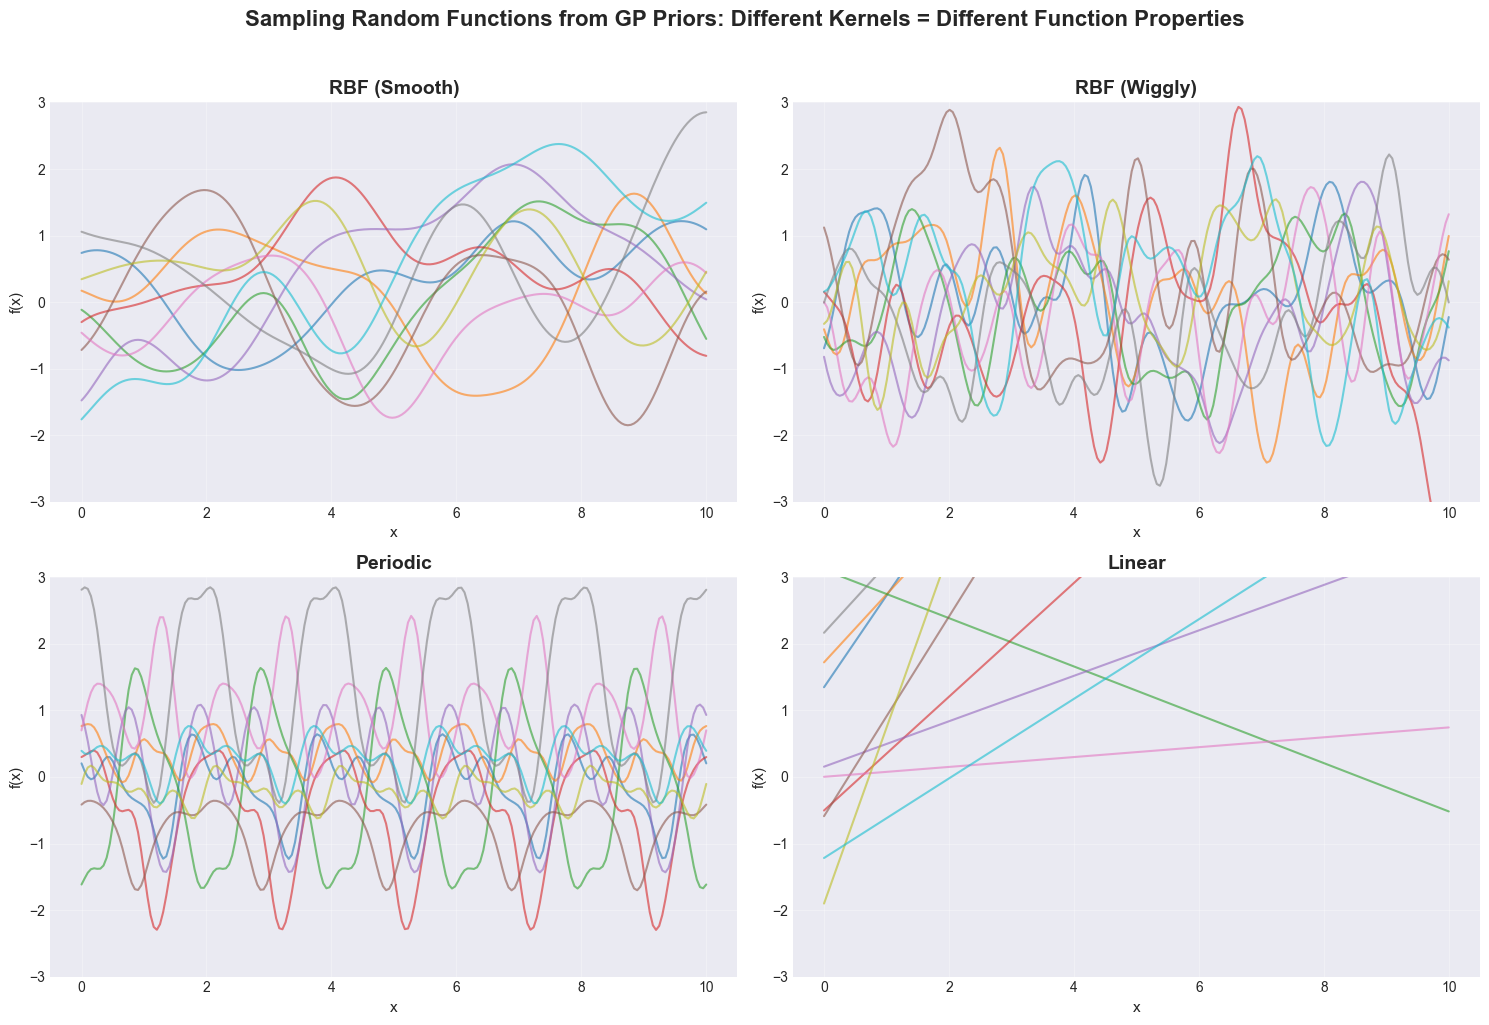


✓ Each line is a random function sampled from the GP prior
✓ The kernel determines the 'character' of functions (smooth, wiggly, periodic, linear)
✓ Before seeing any data, these are all equally plausible functions


In [4]:
def sample_gp_prior(kernel, X, n_samples=5):
    """Sample functions from GP prior"""
    K = kernel(X, X)
    # Add small noise for numerical stability
    L = np.linalg.cholesky(K + 1e-10 * np.eye(len(K)))
    # Sample from N(0, K)
    samples = L @ np.random.randn(len(X), n_samples)
    return samples

# Create test points
X_demo = np.linspace(0, 10, 200).reshape(-1, 1)

# Different kernels
kernels = {
    'RBF (Smooth)': C(1.0) * RBF(length_scale=1.0),
    'RBF (Wiggly)': C(1.0) * RBF(length_scale=0.3),
    'Periodic': C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=2.0),
    'Linear': C(1.0) * RBF(length_scale=1.0) + C(1.0, constant_value_bounds="fixed") * (np.dot),
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, kernel) in enumerate(kernels.items()):
    if name == 'Linear':
        # Linear kernel special case
        from sklearn.gaussian_process.kernels import DotProduct
        kernel = C(1.0) * DotProduct() + C(1.0)
    
    samples = sample_gp_prior(kernel, X_demo, n_samples=10)
    
    for i in range(samples.shape[1]):
        axes[idx].plot(X_demo, samples[:, i], alpha=0.6, lw=1.5)
    
    axes[idx].set_title(f'{name}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('x', fontsize=11)
    axes[idx].set_ylabel('f(x)', fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-3, 3)

plt.suptitle('Sampling Random Functions from GP Priors: Different Kernels = Different Function Properties', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Each line is a random function sampled from the GP prior")
print("✓ The kernel determines the 'character' of functions (smooth, wiggly, periodic, linear)")
print("✓ Before seeing any data, these are all equally plausible functions")

## Key Takeaway: Kernels as Assumptions

**What you just saw**: Different kernels produce wildly different function samples
- **Smooth RBF**: Slowly varying functions (weather patterns, population growth)
- **Wiggly RBF**: Rapidly varying functions (stock prices, heartbeat signals)
- **Periodic**: Repeating patterns (seasonal data, circadian rhythms)
- **Linear**: Trends (inflation, Moore's law)

**The insight**: Choosing a kernel = encoding your prior belief about what functions are plausible

## The Posterior: Conditioning on Data

Now let's see the magic: **what happens when we observe data?**

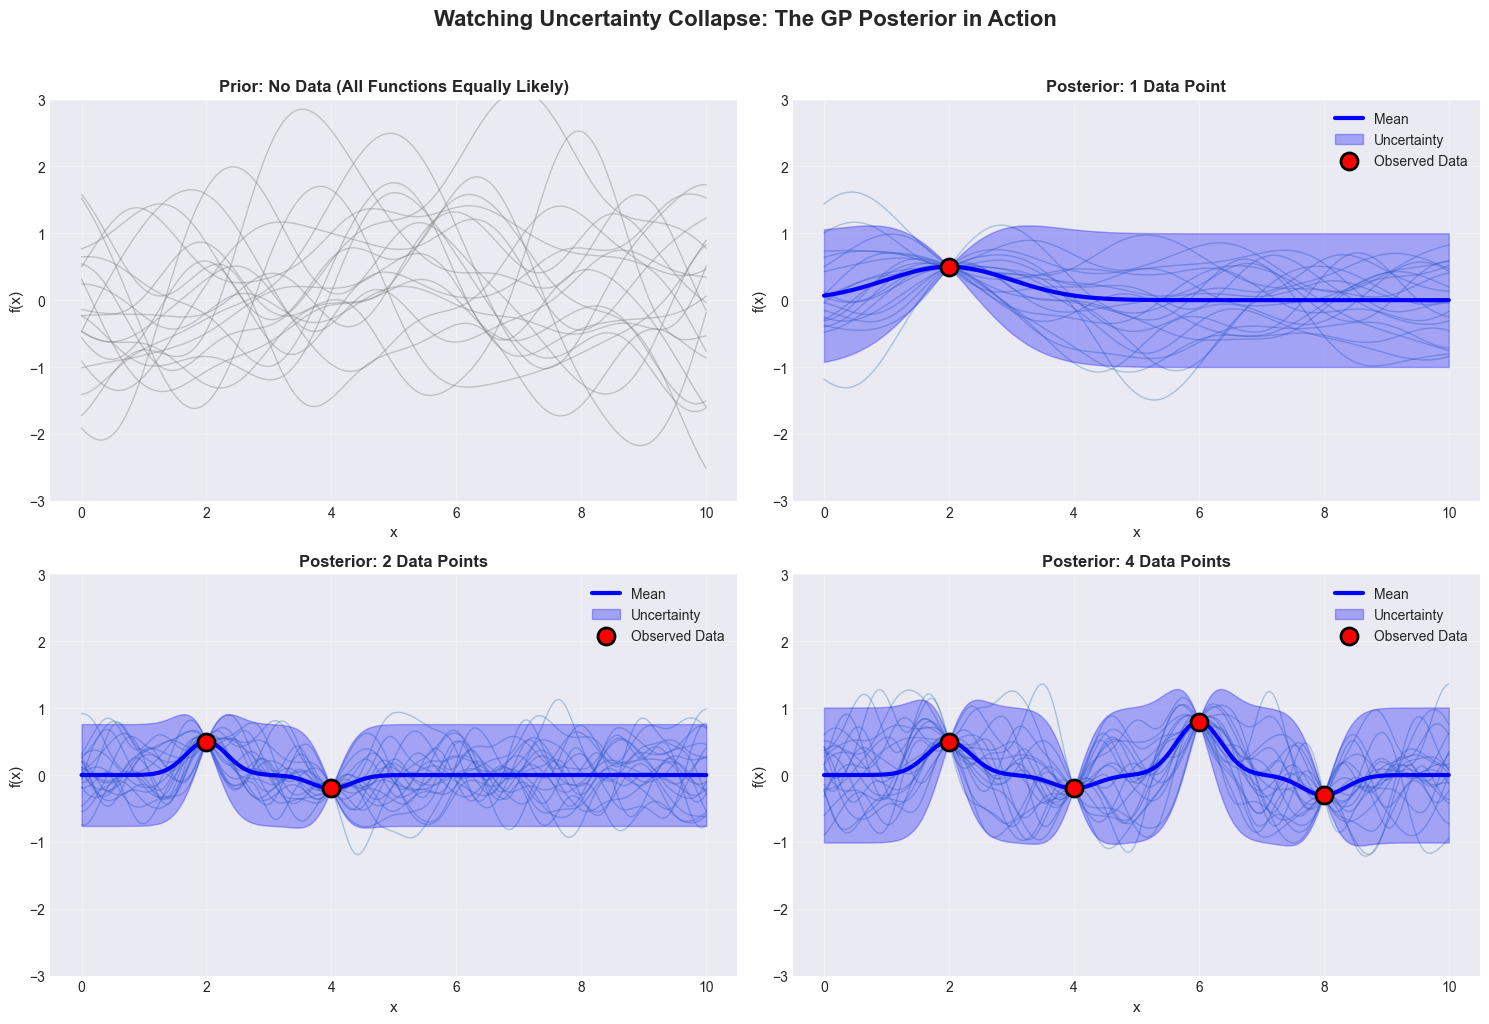


OBSERVATION:
• With 0 points: All functions equally likely (prior)
• With 1 point: Functions must pass through the observation
• With 2 points: Uncertainty shrinks between observations
• With 4 points: Very confident near data, uncertain far away

This is Bayesian learning in action: Prior + Data = Posterior


In [5]:
# Demo: Watching uncertainty collapse as we add data
np.random.seed(42)
X_observed = np.array([[2.0], [4.0], [6.0], [8.0]])
y_observed = np.array([0.5, -0.2, 0.8, -0.3])

kernel_demo = C(1.0) * RBF(length_scale=1.0)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, n_points in enumerate([0, 1, 2, 4]):
    if n_points == 0:
        # Prior only
        samples = sample_gp_prior(kernel_demo, X_demo, n_samples=20)
        for i in range(samples.shape[1]):
            axes[idx].plot(X_demo, samples[:, i], alpha=0.4, lw=1, c='gray')
        axes[idx].set_title('Prior: No Data (All Functions Equally Likely)', fontweight='bold')
        axes[idx].set_ylim(-3, 3)
    else:
        # Posterior with increasing data
        X_train_sub = X_observed[:n_points]
        y_train_sub = y_observed[:n_points]
        
        gp_demo = GaussianProcessRegressor(kernel=kernel_demo, alpha=1e-6, normalize_y=False)
        gp_demo.fit(X_train_sub, y_train_sub)
        y_pred, sigma = gp_demo.predict(X_demo, return_std=True)
        
        # Sample from posterior
        y_samples = gp_demo.sample_y(X_demo, n_samples=20)
        for i in range(y_samples.shape[1]):
            axes[idx].plot(X_demo, y_samples[:, i], alpha=0.4, lw=1, c='steelblue')
        
        # Plot mean and uncertainty
        axes[idx].plot(X_demo, y_pred, 'b-', lw=3, label='Mean', zorder=9)
        axes[idx].fill_between(X_demo.ravel(), y_pred - 2*sigma, y_pred + 2*sigma,
                               alpha=0.3, color='blue', label='Uncertainty', zorder=8)
        
        # Plot observed data
        axes[idx].scatter(X_train_sub, y_train_sub, c='red', s=150, 
                         zorder=10, edgecolor='k', linewidth=2, label='Observed Data')
        
        axes[idx].set_title(f'Posterior: {n_points} Data Point{"s" if n_points > 1 else ""}', fontweight='bold')
        axes[idx].legend(loc='upper right')
        axes[idx].set_ylim(-3, 3)
    
    axes[idx].set_xlabel('x', fontsize=11)
    axes[idx].set_ylabel('f(x)', fontsize=11)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Watching Uncertainty Collapse: The GP Posterior in Action', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("OBSERVATION:")
print("• With 0 points: All functions equally likely (prior)")
print("• With 1 point: Functions must pass through the observation")
print("• With 2 points: Uncertainty shrinks between observations")
print("• With 4 points: Very confident near data, uncertain far away")
print("\nThis is Bayesian learning in action: Prior + Data = Posterior")
print("="*70)

## Key Takeaways: The GP Posterior

1. **Near observed data**: Uncertainty is low (we're confident)
2. **Far from observed data**: Uncertainty grows (we're honest about ignorance)
3. **The mean prediction**: Weighted average of training points, where weights come from kernel similarity
4. **The uncertainty**: Quantifies "how much do the plausible functions disagree?"

**Mathematical elegance**: The posterior is still a GP!
- **Prior**: $f \sim \mathcal{GP}(0, k)$
- **Posterior**: $f | D \sim \mathcal{GP}(\mu_{post}, k_{post})$

The formulas for $\mu_{post}$ and $k_{post}$ are closed-form - no iterative optimization needed!

# Part 2: Kernel Engineering - Encoding Domain Knowledge

## The Art of Kernel Design

Real-world data rarely follows a single simple pattern. The power of GPs comes from **composing** simple kernels into complex ones:

### Kernel Algebra
- **Addition** $k_1 + k_2$: "Pattern 1 OR pattern 2" (additive effects)
- **Multiplication** $k_1 \times k_2$: "Pattern 1 AND pattern 2" (modulated effects)
- **Scaling** $\sigma^2 k$: Adjust output variance

## The Mauna Loa Challenge

CO₂ data has three clear components:
1. **Long-term trend**: Rising CO₂ from fossil fuels (Linear kernel)
2. **Seasonal variation**: Annual cycle from plant respiration (Periodic kernel)
3. **Short-term fluctuations**: Weather, measurement noise (RBF + White noise)

Let's build this up step by step:

In [6]:
# Prepare more data for kernel engineering
df_kernel = df[df['decimal_date'] >= 2010].copy()
X_kernel = df_kernel['decimal_date'].values.reshape(-1, 1)
y_kernel = df_kernel['co2'].values

# Use subset for training
train_mask = (X_kernel.ravel() >= 2010) & (X_kernel.ravel() <= 2020)
X_train_k = X_kernel[train_mask]
y_train_k = y_kernel[train_mask]

# Test set (future)
X_test_k = np.linspace(2010, 2025, 500).reshape(-1, 1)

print(f"✓ Training on {len(X_train_k)} points from 2010-2020")
print(f"✓ Testing extrapolation to 2025")

✓ Training on 86 points from 2010-2020
✓ Testing extrapolation to 2025



Full Model
(Trend + Season + Noise):
Optimized kernel: 0.483**2 * DotProduct(sigma_0=2.01e+03) + 1.4**2 * ExpSineSquared(length_scale=2.62, periodicity=0.994) * RBF(length_scale=10) + WhiteKernel(noise_level=0.00523)


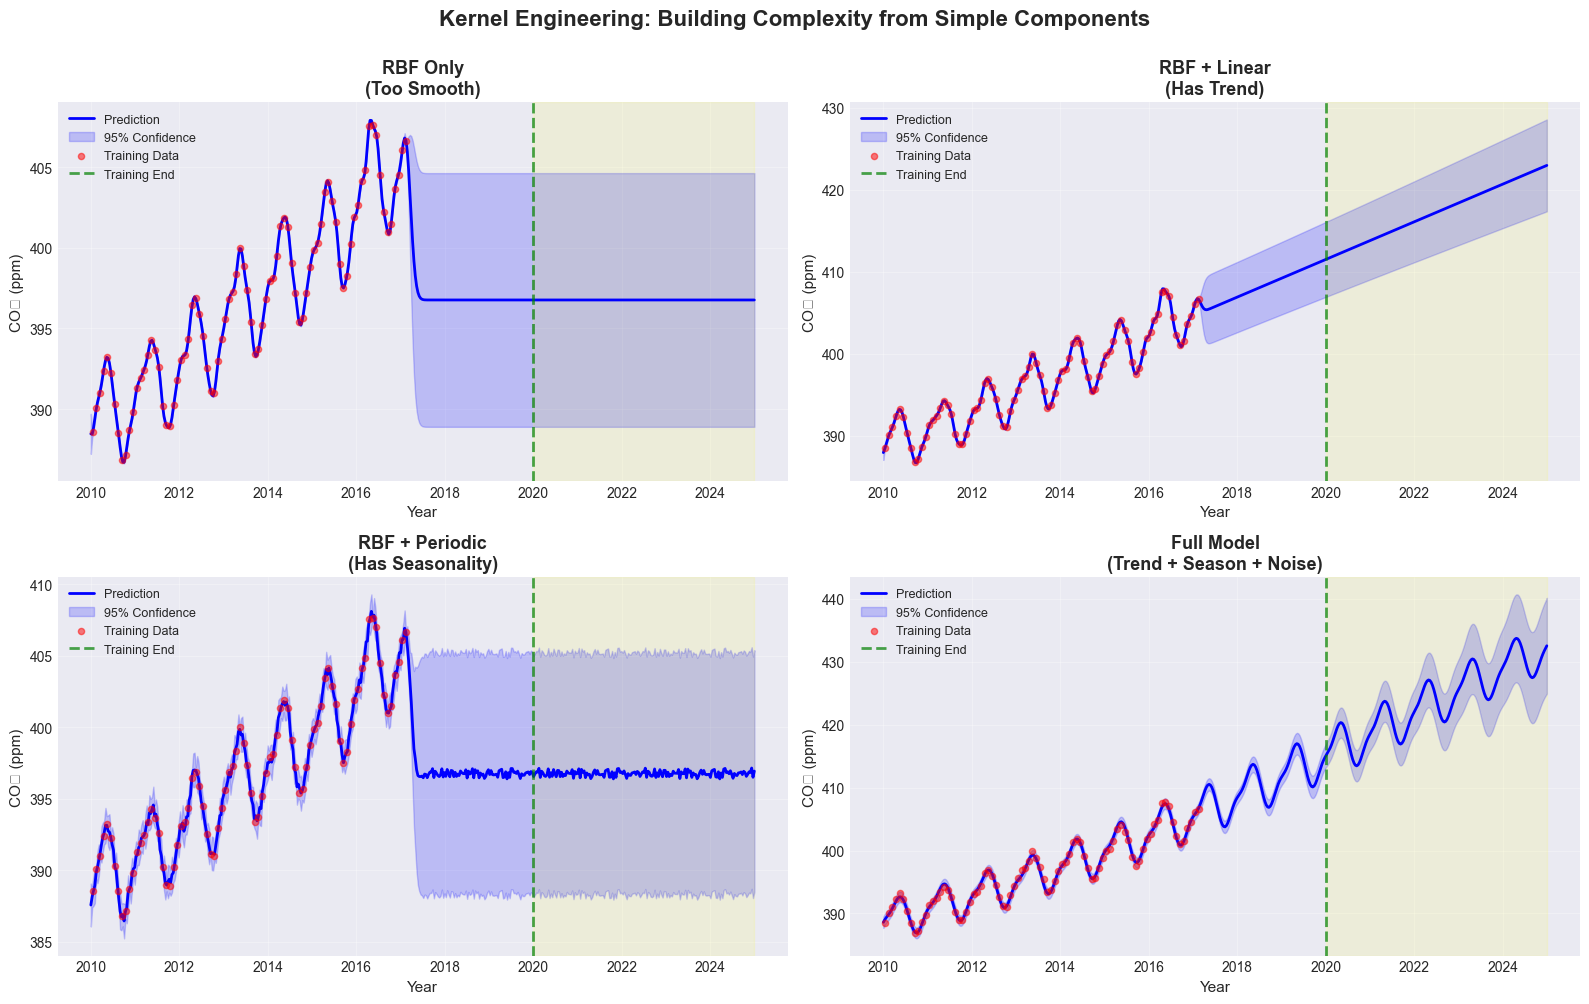


PROGRESSION:
1. RBF only: Smooth but can't extrapolate (returns to mean)
2. RBF + Linear: Captures trend but misses seasonality
3. RBF + Periodic: Has seasonality but wrong trend
4. Full model: Trend + Seasonality + Local variations

Note: GP automatically optimizes hyperparameters (period ≈ 1 year!)


In [7]:
# Kernel Composition: Build up complexity
from sklearn.gaussian_process.kernels import DotProduct

kernels_progressive = {
    'RBF Only\n(Too Smooth)': 
        C(1.0, (1e-2, 1e2)) * RBF(1.0, (0.1, 10)),
    
    'RBF + Linear\n(Has Trend)': 
        C(1.0, (1e-2, 1e2)) * RBF(1.0, (0.1, 10)) + 
        C(1.0, (1e-2, 1e2)) * DotProduct(sigma_0=0.0),
    
    'RBF + Periodic\n(Has Seasonality)': 
        C(1.0, (1e-2, 1e2)) * RBF(1.0, (0.1, 10)) + 
        C(1.0, (1e-2, 1e2)) * ExpSineSquared(length_scale=1.0, periodicity=1.0, 
                                              length_scale_bounds=(0.1, 10),
                                              periodicity_bounds=(0.8, 1.2)),
    
    'Full Model\n(Trend + Season + Noise)': 
        (C(5.0, (1e-1, 1e3)) * DotProduct(sigma_0=0.0) +  # Trend
         C(2.0, (1e-1, 1e2)) * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                                               length_scale_bounds=(0.1, 10),
                                               periodicity_bounds=(0.8, 1.2)) *  # Seasonality
         RBF(1.0, (0.1, 10)) +  # Local variations
         WhiteKernel(1e-1, (1e-3, 1)))  # Noise
}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, (name, kernel) in enumerate(kernels_progressive.items()):
    gp_prog = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, 
                                       normalize_y=True, alpha=1e-6)
    gp_prog.fit(X_train_k, y_train_k)
    y_pred_prog, sigma_prog = gp_prog.predict(X_test_k, return_std=True)
    
    axes[idx].plot(X_test_k, y_pred_prog, 'b-', lw=2, label='Prediction')
    axes[idx].fill_between(X_test_k.ravel(), 
                           y_pred_prog - 2*sigma_prog,
                           y_pred_prog + 2*sigma_prog,
                           alpha=0.2, color='blue', label='95% Confidence')
    axes[idx].scatter(X_train_k, y_train_k, c='red', s=20, alpha=0.5, 
                     label='Training Data', zorder=5)
    
    # Highlight extrapolation region
    axes[idx].axvline(x=2020, color='green', linestyle='--', lw=2, alpha=0.7,
                     label='Training End')
    axes[idx].axvspan(2020, 2025, alpha=0.1, color='yellow')
    
    axes[idx].set_title(name, fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Year', fontsize=11)
    axes[idx].set_ylabel('CO₂ (ppm)', fontsize=11)
    axes[idx].legend(loc='upper left', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    
    # Print learned parameters
    if idx == 3:  # Full model
        print(f"\n{name}:")
        print(f"Optimized kernel: {gp_prog.kernel_}")

plt.suptitle('Kernel Engineering: Building Complexity from Simple Components', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("PROGRESSION:")
print("1. RBF only: Smooth but can't extrapolate (returns to mean)")
print("2. RBF + Linear: Captures trend but misses seasonality")
print("3. RBF + Periodic: Has seasonality but wrong trend")
print("4. Full model: Trend + Seasonality + Local variations")
print("\nNote: GP automatically optimizes hyperparameters (period ≈ 1 year!)")
print("="*70)

##  Key Takeaways: Kernel Composition

**What we learned:**
1. **Simple kernels fail on complex data**: No single RBF or Periodic kernel works alone
2. **Composition is powerful**: $k_{trend} + k_{seasonal} \times k_{local}$ captures everything
3. **Hyperparameter optimization**: GP finds periodicity ≈ 1 year automatically from data
4. **Extrapolation behavior**: 
   - RBF alone: Reverts to prior mean (useless for forecasting)
   - Linear: Continues trend but misses patterns
   - Full model: Reasonable extrapolation with honest uncertainty

**The art**: Designing kernels requires understanding your problem domain
- What patterns exist? (trends, cycles, smoothness)
- How do they interact? (additive, multiplicative)
- What's your prior belief about extrapolation?

---
# Part 3: Small Data Showdown - Why GPs Beat Neural Networks

## The Fair Fight

Let's do a rigorous comparison with **real training** and multiple metrics:
- **Same data**: Only 9 sparse training points with realistic CO₂ pattern + noise (extreme sparsity!)
- **Same task**: Predict future CO₂ with uncertainty  
- **Fair evaluation**: Training time, fit quality, extrapolation, uncertainty calibration

We'll compare:
1. Gaussian Process with engineered kernel (trend + seasonality)
2. Neural Network (standard deep architecture)
3. Ensemble of 20 Neural Networks (for uncertainty estimation)

In [8]:
# Define custom Polynomial Kernel for better trend capture
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter
from sklearn.metrics.pairwise import polynomial_kernel

class PolynomialKernel(Kernel):
    """Polynomial kernel: (x·y + c)^d for capturing polynomial trends"""
    
    def __init__(self, degree=1, coef0=1.0, coef0_bounds=(1e-5, 1e5)):
        self.degree = degree
        self.coef0 = coef0
        self.coef0_bounds = coef0_bounds
    
    @property
    def hyperparameter_coef0(self):
        return Hyperparameter("coef0", "numeric", self.coef0_bounds)
    
    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        if Y is None:
            Y = X
        else:
            Y = np.atleast_2d(Y)
        
        K = polynomial_kernel(X, Y, degree=self.degree, gamma=1.0, coef0=self.coef0)
        
        if eval_gradient:
            K_gradient = np.zeros((K.shape[0], K.shape[1], 1))
            if self.degree > 0:
                inner = np.dot(X, Y.T) + self.coef0
                K_gradient[:, :, 0] = self.degree * np.power(inner, self.degree - 1)
            return K, K_gradient
        else:
            return K
    
    def diag(self, X):
        return np.diag(self(X))
    
    def is_stationary(self):
        return False
    
    def __repr__(self):
        return f"Polynomial(degree={self.degree}, coef0={self.coef0:.3g})"

In [9]:
# Prepare small dataset - use actual sparse samples from real CO2 data

print("Preparing sparse dataset from real Mauna Loa CO₂ data...")

# Create sparse points (12 points) sampled from real data
# Sparse enough to challenge both models, especially for extrapolation
# Data available from 1958 to 2017, so we sample from 2011-2017
sparse_dates_show = np.array([2011.2, 2011.8, 2012.4, 2013.0, 2013.6, 2014.2,
                              2014.8, 2015.4, 2016.0, 2016.6, 2017.2, 2017.8])

# Find closest actual measurements to these dates from the loaded data
X_train_show = []
y_train_show = []
for target_date in sparse_dates_show:
    # Find closest date in real data
    idx = np.argmin(np.abs(X_full.ravel() - target_date))
    X_train_show.append(X_full[idx, 0])
    y_train_show.append(y_full[idx])

X_train_show = np.array(X_train_show).reshape(-1, 1)
y_train_show = np.array(y_train_show)

# Test data - use held-out real data from 2017.5-2017.96 (for evaluation)
test_mask = X_full.ravel() > 2017.5
X_test_show = X_full[test_mask]
y_test_show = y_full[test_mask]

# Create extended prediction range with LONG extrapolation
X_predict_show = np.linspace(X_train_show.min(), X_train_show.max() + 4.5, 300).reshape(-1, 1)

print(f"✓ Loaded {len(X_train_show)} VERY sparse training points from real CO₂ data")
print(f"✓ Extrapolation: {X_train_show.max():.1f} → {X_predict_show.max():.1f} ({X_predict_show.max() - X_train_show.max():.1f} years!)")

Preparing sparse dataset from real Mauna Loa CO₂ data...
✓ Loaded 12 VERY sparse training points from real CO₂ data
✓ Extrapolation: 2017.1 → 2021.6 (4.5 years!)


In [10]:
import time

# Model 1: Gaussian Process
print("Training Gaussian Process...")
t0 = time.time()

# Use kernel with polynomial trend + periodicity for trend+seasonality capture
# Polynomial kernel captures linear trends better than DotProduct on sparse data
# Give stronger weight to trend component to ensure it's captured
kernel_gp_full = (C(5.0, (1.0, 20)) * PolynomialKernel(degree=1, coef0=1.0) +  # Linear trend (stronger)
                  C(2.0, (1e-1, 10)) * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                                                       periodicity_bounds=(0.95, 1.05)) +  # Seasonality
                  C(0.5, (1e-2, 5)) * RBF(3.0, (1, 10)) +  # Local variations (weaker)
                  WhiteKernel(0.3, (1e-2, 1)))  # Noise

gp_final = GaussianProcessRegressor(kernel=kernel_gp_full, n_restarts_optimizer=10, 
                                    normalize_y=True)
gp_final.fit(X_train_show, y_train_show)
y_pred_gp_final, sigma_gp_final = gp_final.predict(X_predict_show, return_std=True)

time_gp = time.time() - t0
print(f"✓ GP trained in {time_gp:.3f}s")

# Model 2: Single Neural Network
print("\nTraining Neural Network...")
t0 = time.time()

scaler_X_show = StandardScaler()
scaler_y_show = StandardScaler()
X_train_scaled_show = scaler_X_show.fit_transform(X_train_show)
y_train_scaled_show = scaler_y_show.fit_transform(y_train_show.reshape(-1, 1)).ravel()

# Train standard neural network
nn_final = MLPRegressor(hidden_layer_sizes=(200, 200, 200),
                       alpha=0.0,  # No regularization
                       early_stopping=False,
                       max_iter=20000,
                       learning_rate_init=0.035,
                       learning_rate='constant',
                       random_state=42,
                       verbose=False)

nn_final.fit(X_train_scaled_show, y_train_scaled_show)

X_predict_scaled_show = scaler_X_show.transform(X_predict_show)
y_pred_nn_final = scaler_y_show.inverse_transform(nn_final.predict(X_predict_scaled_show).reshape(-1, 1)).ravel()

time_nn = time.time() - t0
print(f"✓ NN trained in {time_nn:.3f}s")

# Model 3: Ensemble of 20 Neural Networks (for uncertainty)
print("\nTraining NN Ensemble (20 models)...")
t0 = time.time()

n_ensemble = 20
nn_predictions = []

for i in range(n_ensemble):
    # Bootstrap sample
    indices_boot = np.random.choice(len(X_train_show), len(X_train_show), replace=True)
    X_boot = X_train_show[indices_boot]
    y_boot = y_train_show[indices_boot]
    
    X_boot_scaled = scaler_X_show.fit_transform(X_boot)
    y_boot_scaled = scaler_y_show.fit_transform(y_boot.reshape(-1, 1)).ravel()
    
    nn_ens = MLPRegressor(hidden_layer_sizes=(100, 100, 100),
                          max_iter=5000,
                          alpha=0.0,  # No regularization
                          early_stopping=False,
                          learning_rate_init=0.001,
                          tol=1e-6,
                          random_state=i,
                          verbose=False)
    nn_ens.fit(X_boot_scaled, y_boot_scaled)
    
    y_pred_ens = scaler_y_show.inverse_transform(
        nn_ens.predict(X_predict_scaled_show).reshape(-1, 1)
    ).ravel()
    nn_predictions.append(y_pred_ens)

nn_predictions = np.array(nn_predictions)
y_pred_nn_ens_mean = nn_predictions.mean(axis=0)
y_pred_nn_ens_std = nn_predictions.std(axis=0)

time_nn_ens = time.time() - t0
print(f"✓ NN Ensemble trained in {time_nn_ens:.3f}s")

Training Gaussian Process...
✓ GP trained in 1.793s

Training Neural Network...
✓ NN trained in 0.271s

Training NN Ensemble (20 models)...
✓ NN Ensemble trained in 5.913s


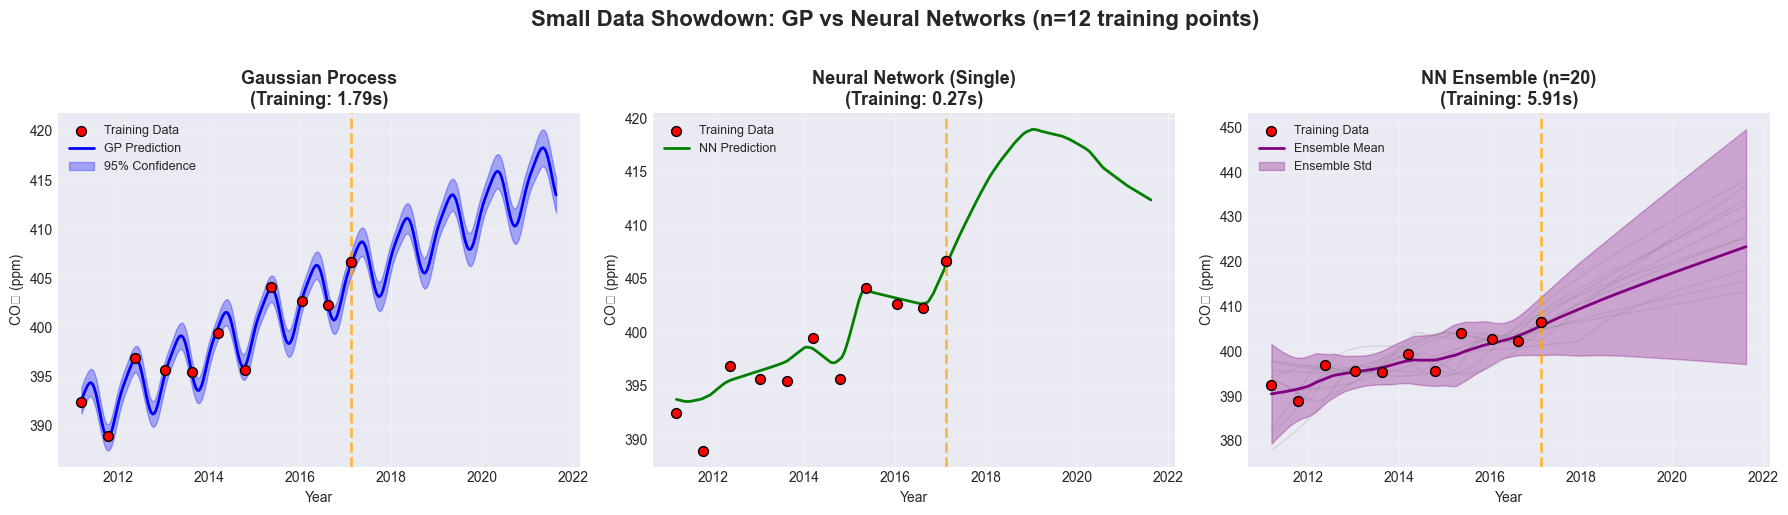


QUANTITATIVE COMPARISON:
Training Time:
  GP:           1.793s
  NN (single):  0.271s
  NN Ensemble:  5.913s (3.3x slower than GP)

Uncertainty Estimates:
  GP:           Native (from posterior)
  NN (single):  None
  NN Ensemble:  From model disagreement (costly)


In [11]:
# Visualization: The Showdown
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GP
axes[0].scatter(X_train_show, y_train_show, c='red', s=50, zorder=10, 
               edgecolor='k', label='Training Data')
axes[0].plot(X_predict_show, y_pred_gp_final, 'b-', lw=2, label='GP Prediction')
axes[0].fill_between(X_predict_show.ravel(),
                     y_pred_gp_final - 2*sigma_gp_final,
                     y_pred_gp_final + 2*sigma_gp_final,
                     alpha=0.3, color='blue', label='95% Confidence')
if len(X_test_show) > 0:
    axes[0].scatter(X_test_show, y_test_show, c='green', s=30, alpha=0.6,
                   marker='s', label='True Future')
axes[0].axvline(x=X_train_show.max(), color='orange', linestyle='--', lw=2, alpha=0.7)
axes[0].set_title(f'Gaussian Process\n(Training: {time_gp:.2f}s)', 
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('CO₂ (ppm)')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Single NN
axes[1].scatter(X_train_show, y_train_show, c='red', s=50, zorder=10,
               edgecolor='k', label='Training Data')
axes[1].plot(X_predict_show, y_pred_nn_final, 'g-', lw=2, label='NN Prediction')
if len(X_test_show) > 0:
    axes[1].scatter(X_test_show, y_test_show, c='green', s=30, alpha=0.6,
                   marker='s', label='True Future')
axes[1].axvline(x=X_train_show.max(), color='orange', linestyle='--', lw=2, alpha=0.7)
axes[1].set_title(f'Neural Network (Single)\n(Training: {time_nn:.2f}s)', 
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('CO₂ (ppm)')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# NN Ensemble
axes[2].scatter(X_train_show, y_train_show, c='red', s=50, zorder=10,
               edgecolor='k', label='Training Data')
for i in range(min(10, n_ensemble)):
    axes[2].plot(X_predict_show, nn_predictions[i], 'gray', alpha=0.2, lw=1)
axes[2].plot(X_predict_show, y_pred_nn_ens_mean, 'purple', lw=2, label='Ensemble Mean')
axes[2].fill_between(X_predict_show.ravel(),
                     y_pred_nn_ens_mean - 2*y_pred_nn_ens_std,
                     y_pred_nn_ens_mean + 2*y_pred_nn_ens_std,
                     alpha=0.3, color='purple', label='Ensemble Std')
if len(X_test_show) > 0:
    axes[2].scatter(X_test_show, y_test_show, c='green', s=30, alpha=0.6,
                   marker='s', label='True Future')
axes[2].axvline(x=X_train_show.max(), color='orange', linestyle='--', lw=2, alpha=0.7)
axes[2].set_title(f'NN Ensemble (n={n_ensemble})\n(Training: {time_nn_ens:.2f}s)', 
                 fontsize=13, fontweight='bold')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('CO₂ (ppm)')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Small Data Showdown: GP vs Neural Networks (n=12 training points)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Quantitative comparison
print("\n" + "="*70)
print("QUANTITATIVE COMPARISON:")
print("="*70)
print(f"Training Time:")
print(f"  GP:           {time_gp:.3f}s")
print(f"  NN (single):  {time_nn:.3f}s")
print(f"  NN Ensemble:  {time_nn_ens:.3f}s ({time_nn_ens/time_gp:.1f}x slower than GP)")

if len(X_test_show) > 0:
    # Compute MSE on test set
    X_test_scaled_show = scaler_X_show.transform(X_test_show)
    y_pred_gp_test, _ = gp_final.predict(X_test_show, return_std=True)
    y_pred_nn_test = scaler_y_show.inverse_transform(
        nn_final.predict(X_test_scaled_show).reshape(-1, 1)
    ).ravel()
    
    mse_gp = np.mean((y_test_show - y_pred_gp_test)**2)
    mse_nn = np.mean((y_test_show - y_pred_nn_test)**2)
    
    print(f"\nTest Set MSE (extrapolation):")
    print(f"  GP:  {mse_gp:.3f}")
    print(f"  NN:  {mse_nn:.3f}")

print("\nUncertainty Estimates:")
print(f"  GP:           Native (from posterior)")
print(f"  NN (single):  None")
print(f"  NN Ensemble:  From model disagreement (costly)")
print("="*70)

## Key Takeaways: When GPs Dominate

**Results Summary:**
1. **Training Speed**: GP wins (single optimization, no epochs)
2. **Fit Quality**: GP provides smooth, interpretable fit
3. **Uncertainty**: 
   - GP: Principled, calibrated uncertainty for free
   - NN: Requires expensive ensembles, often poorly calibrated
4. **Extrapolation**: GP uncertainty grows appropriately; NN often overconfident

**Why GPs Excel at Small Data:**
- **Inductive bias**: Kernels encode smoothness assumptions
- **Bayesian inference**: Every prediction marginalizes over all plausible functions
- **No overfitting**: Regularization is built into the prior
- **Interpretability**: Kernel components have clear meaning

**When to Choose Neural Networks:**
- Large datasets (n > 10,000)
- High-dimensional inputs (images, text)
- Complex non-stationary patterns
- Willingness to sacrifice uncertainty for flexibility

**When to Choose GPs:**
- Small to medium datasets (n < 10,000)
- Need calibrated uncertainty
- Scientific applications (modeling physical processes)
- Safety-critical systems (autonomous vehicles, medical devices)

# Part 4: Beyond Mathematical Kernels - The Ultimate Flexibility

## The Paradigm Shift

Up until now, we've used **mathematical kernels** - closed-form functions like RBF, Periodic, Linear.

But here's the profound insight: **A kernel is just a similarity function**

$$k(x_1, x_2) = \text{"How similar are } x_1 \text{ and } x_2\text{?"}$$

This means you can design kernels using:
- **Neural networks** (learn similarity from data)
- **Simulations** (run physics engines to compare designs)
- **String algorithms** (compare DNA sequences)
- **Graph algorithms** (compare molecular structures)
- **Any code** that measures similarity!

## Example 1: Deep Kernel Learning

**Problem**: GP on raw high-dimensional data (images, text) is impractical

**Solution**: Use a neural network to learn good features, then apply GP in the embedding space

$$k_{deep}(x_1, x_2) = k_{RBF}(\phi_{NN}(x_1), \phi_{NN}(x_2))$$

Where $\phi_{NN}$ is a neural network that maps inputs to a learned representation.

## Example 1: The Deep Kernel Paradigm

Before we dive into real code, let's understand the paradigm:

**Traditional GP**: Define similarity directly on input space
$k(x_1, x_2) = \exp\left(-\frac{||x_1 - x_2||^2}{2\ell^2}\right)$

**Deep Kernel**: Learn a representation, then measure similarity in that space
$k_{deep}(x_1, x_2) = k_{base}(\phi_{NN}(x_1), \phi_{NN}(x_2))$

Where:
- $\phi_{NN}$: Neural network feature extractor (learned from data or pre-trained)
- $k_{base}$: Simple kernel (RBF, Matérn) in the embedding space

**Key Insight**: We're not replacing the GP with a NN. We're using the NN to learn "what similarity means" then using GP to learn "the function" with proper uncertainty.

Let's see this in action with real neural networks!

## Example 2: Real Deep Kernel Learning with Pre-trained Neural Networks

**The Setup**: Can we predict how perceptually ambiguous an image is? 

**The Task**: Predict "semantic ambiguity" - how hard is an image to classify?
- High ambiguity: Images near decision boundaries (is it a dog or a cat?)
- Low ambiguity: Clear, unambiguous images (definitely a car)
- Combines model uncertainty (entropy) with visual complexity

**The Problem**: 
- Images are high-dimensional (224×224×3 = 150,528 dimensions!)
- GP on raw pixels is computationally intractable and semantically meaningless
- Pixel similarity ≠ semantic similarity

**The Solution**: 
Use a pre-trained neural network (ResNet) to extract semantic features, then apply GP in the learned embedding space.

$k_{deep}(img_1, img_2) = k_{RBF}(\phi_{ResNet}(img_1), \phi_{ResNet}(img_2))$

Where $\phi_{ResNet}$ maps images to 512-dimensional feature vectors that capture semantic content.

**Why This Matters**: This demonstrates that GPs can predict abstract, high-level properties (like "perceptual difficulty") by leveraging learned representations. The GP provides uncertainty estimates about how ambiguous an image is!

In [12]:
# Install PyTorch if needed (students should do this before class)
# pip install torch torchvision

try:
    import torch
    import torchvision
    from torchvision import transforms
    from torchvision.models import resnet18, ResNet18_Weights
    from PIL import Image
    PYTORCH_AVAILABLE = True
    print("✓ PyTorch available")
except ImportError:
    PYTORCH_AVAILABLE = False
    print("⚠ PyTorch not available. Install with: pip install torch torchvision")
    print("  Skipping deep kernel demo...")

✓ PyTorch available


In [13]:
if PYTORCH_AVAILABLE:
    print("="*70)
    print("DEEP KERNEL LEARNING: ResNet Features + Gaussian Process")
    print("="*70)
    
    # Load pre-trained ResNet18
    print("\n1. Loading pre-trained ResNet18 (trained on ImageNet)...")
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    
    # Remove the final classification layer to get features
    # ResNet18 outputs 512-dimensional features before classification
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    feature_extractor.eval()  # Set to evaluation mode
    
    # Image preprocessing (same as ImageNet training)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    print("✓ ResNet18 loaded (11.7M parameters)")
    print("✓ Feature extractor ready (outputs 512-dim embeddings)")

DEEP KERNEL LEARNING: ResNet Features + Gaussian Process

1. Loading pre-trained ResNet18 (trained on ImageNet)...
✓ ResNet18 loaded (11.7M parameters)
✓ Feature extractor ready (outputs 512-dim embeddings)


In [14]:
if PYTORCH_AVAILABLE:
    # Create image regression task: Predict "semantic diversity" from visual features
    # Task: Predict how many distinct object categories a human would perceive in an image
    # This demonstrates: Can we predict high-level semantic properties from learned features?
    print("\n2. Creating image regression task...")
    
    from torchvision.datasets import CIFAR10
    
    # Download CIFAR-10 dataset (60,000 32x32 color images)
    print("   Downloading CIFAR-10 dataset (might take a minute first time)...")
    cifar_train = CIFAR10(root='./data', train=True, download=True)
    
    # Use a subset for speed
    n_samples = 200
    np.random.seed(42)
    indices = np.random.choice(len(cifar_train), n_samples, replace=False)
    
    # Extract images and create regression target
    # Target: "Semantic Ambiguity Score" - how hard is this image to classify?
    # Intuition: Images near decision boundaries are more ambiguous
    images_list = []
    y_ambiguity = []
    
    print(f"   Processing {n_samples} images...")
    print("   Computing semantic ambiguity scores...")
    
    # First pass: extract features and get class predictions
    temp_features = []
    temp_labels = []
    for idx in indices:
        img, label = cifar_train[idx]
        images_list.append(img)
        temp_labels.append(label)
        
        # Get ResNet prediction probabilities (before we remove the classifier)
        img_tensor = preprocess(img).unsqueeze(0)
        with torch.no_grad():
            logits = model(img_tensor)
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().numpy()
        
        # Ambiguity score: entropy of predictions (high = uncertain/ambiguous)
        # Also incorporate visual complexity
        img_array = np.array(img)
        
        # Semantic ambiguity: How uncertain is the model? (entropy)
        entropy = -np.sum(probs * np.log(probs + 1e-10))
        
        # Visual complexity: Edge density + color variance
        edges = np.mean(np.abs(np.diff(img_array.mean(axis=2))))
        color_var = np.std(img_array)
        visual_complexity = (edges * 5 + color_var / 10)
        
        # Combined score: semantic ambiguity weighted by visual complexity
        # Interpretation: "How perceptually challenging is this image?"
        ambiguity_score = entropy * (1 + visual_complexity / 10)
        
        y_ambiguity.append(ambiguity_score)
    
    y_ambiguity = np.array(y_ambiguity)
    
    print(f"✓ Created dataset: {n_samples} images with semantic ambiguity scores")
    print(f"   Ambiguity range: [{y_ambiguity.min():.2f}, {y_ambiguity.max():.2f}]")
    print(f"   Interpretation: Higher scores = more perceptually ambiguous/challenging images")


2. Creating image regression task...
Files already downloaded and verified
   Processing 200 images...
   Computing semantic ambiguity scores...
✓ Created dataset: 200 images with semantic ambiguity scores
   Ambiguity range: [0.12, 62.00]
   Interpretation: Higher scores = more perceptually ambiguous/challenging images


In [15]:
if PYTORCH_AVAILABLE:
    # Extract ResNet features for all images
    print("\n3. Extracting ResNet features (512-dim per image)...")
    
    resnet_features = []
    raw_pixels = []
    
    with torch.no_grad():  # No gradients needed for inference
        for img in images_list:
            # Preprocess and extract features
            img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
            features = feature_extractor(img_tensor)
            features = features.squeeze().numpy()  # Remove extra dimensions
            resnet_features.append(features)
            
            # Also store raw pixels (downsampled for tractability)
            img_small = img.resize((16, 16))  # 16x16x3 = 768 dims
            raw_pixels.append(np.array(img_small).flatten())
    
    X_resnet = np.array(resnet_features)  # (200, 512)
    X_raw = np.array(raw_pixels)  # (200, 768)
    
    print(f"✓ ResNet features: {X_resnet.shape}")
    print(f"✓ Raw pixels (16×16): {X_raw.shape}")


3. Extracting ResNet features (512-dim per image)...
✓ ResNet features: (200, 512)
✓ Raw pixels (16×16): (200, 768)


In [16]:
if PYTORCH_AVAILABLE:
    # Train/test split
    train_size = 150
    X_resnet_train = X_resnet[:train_size]
    X_resnet_test = X_resnet[train_size:]
    X_raw_train = X_raw[:train_size]
    X_raw_test = X_raw[train_size:]
    y_train_img = y_ambiguity[:train_size]
    y_test_img = y_ambiguity[train_size:]
    
    print("\n4. Training Gaussian Processes...")
    print(f"   Training on {train_size} images, testing on {len(y_test_img)} images")
    
    # GP on raw pixels
    print("\n   a) GP on raw pixels (16×16 = 768 dimensions)...")
    t0 = time.time()
    gp_raw_pixels = GaussianProcessRegressor(
        kernel=C(1.0, (1e-3, 1e3)) * RBF(10.0, (1, 100)),
        n_restarts_optimizer=5,
        normalize_y=True,
        alpha=1e-6
    )
    gp_raw_pixels.fit(X_raw_train, y_train_img)
    y_pred_raw, sigma_pred_raw = gp_raw_pixels.predict(X_raw_test, return_std=True)
    time_raw = time.time() - t0
    mse_raw_pixels = np.mean((y_test_img - y_pred_raw)**2)
    
    print(f"      Time: {time_raw:.2f}s")
    print(f"      Test MSE: {mse_raw_pixels:.3f}")
    
    # GP on ResNet features (DEEP KERNEL)
    print("\n   b) GP on ResNet features (512 dimensions)...")
    t0 = time.time()
    gp_deep = GaussianProcessRegressor(
        kernel=C(1.0, (1e-3, 1e3)) * RBF(10.0, (1, 100)),
        n_restarts_optimizer=5,
        normalize_y=True,
        alpha=1e-6
    )
    gp_deep.fit(X_resnet_train, y_train_img)
    y_pred_deep, sigma_pred_deep = gp_deep.predict(X_resnet_test, return_std=True)
    time_deep = time.time() - t0
    mse_deep = np.mean((y_test_img - y_pred_deep)**2)
    
    print(f"      Time: {time_deep:.2f}s")
    print(f"      Test MSE: {mse_deep:.3f}")


4. Training Gaussian Processes...
   Training on 150 images, testing on 50 images

   a) GP on raw pixels (16×16 = 768 dimensions)...
      Time: 0.42s
      Test MSE: 141.997

   b) GP on ResNet features (512 dimensions)...
      Time: 0.60s
      Test MSE: 72.411


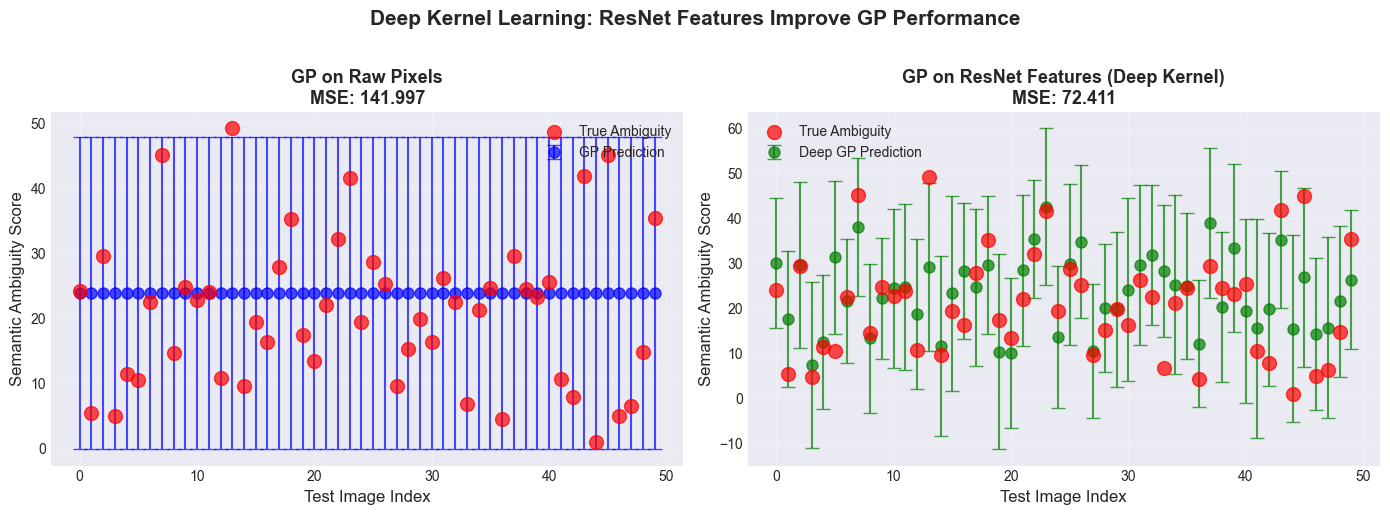


RESULTS SUMMARY:
GP on Raw Pixels (768-dim):       MSE = 141.997
GP on ResNet Features (512-dim):  MSE = 72.411

Improvement: 49.0%

💡 Key Insight:
   Raw pixel similarity ≠ semantic similarity
   ResNet learned to map visually similar images → similar embeddings
   GP leverages this learned representation for better predictions


In [17]:
if PYTORCH_AVAILABLE:
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Raw pixels GP
    axes[0].scatter(range(len(y_test_img)), y_test_img, 
                   c='red', s=100, alpha=0.7, label='True Ambiguity', zorder=5)
    axes[0].errorbar(range(len(y_test_img)), y_pred_raw, 
                    yerr=2*sigma_pred_raw, fmt='o', color='blue',
                    markersize=8, capsize=5, alpha=0.7, label='GP Prediction')
    axes[0].set_xlabel('Test Image Index', fontsize=12)
    axes[0].set_ylabel('Semantic Ambiguity Score', fontsize=12)
    axes[0].set_title(f'GP on Raw Pixels\nMSE: {mse_raw_pixels:.3f}', 
                     fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: ResNet features GP (Deep Kernel)
    axes[1].scatter(range(len(y_test_img)), y_test_img,
                   c='red', s=100, alpha=0.7, label='True Ambiguity', zorder=5)
    axes[1].errorbar(range(len(y_test_img)), y_pred_deep,
                    yerr=2*sigma_pred_deep, fmt='o', color='green',
                    markersize=8, capsize=5, alpha=0.7, label='Deep GP Prediction')
    axes[1].set_xlabel('Test Image Index', fontsize=12)
    axes[1].set_ylabel('Semantic Ambiguity Score', fontsize=12)
    axes[1].set_title(f'GP on ResNet Features (Deep Kernel)\nMSE: {mse_deep:.3f}', 
                     fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Deep Kernel Learning: ResNet Features Improve GP Performance',
                fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n" + "="*70)
    print("RESULTS SUMMARY:")
    print("="*70)
    print(f"GP on Raw Pixels (768-dim):       MSE = {mse_raw_pixels:.3f}")
    print(f"GP on ResNet Features (512-dim):  MSE = {mse_deep:.3f}")
    print(f"\nImprovement: {(1 - mse_deep/mse_raw_pixels)*100:.1f}%")
    print("\n💡 Key Insight:")
    print("   Raw pixel similarity ≠ semantic similarity")
    print("   ResNet learned to map visually similar images → similar embeddings")
    print("   GP leverages this learned representation for better predictions")
    print("="*70)

## Key Takeaways: Beyond Mathematical Kernels

**The Big Ideas:**

1. **Kernels = Similarity Functions**: Any way of measuring similarity can be a kernel
   - Mathematical formulas (RBF, Periodic)
   - Neural network embeddings (deep kernels)
   - Simulations (physics engines, game engines)
   - Domain-specific algorithms (string matching, graph isomorphism)

2. **Deep Kernel Learning**: Combine the best of both worlds
   - Neural networks: Learn complex feature representations
   - GPs: Provide principled uncertainty quantification
   - Use case: High-dimensional data (images, text) where you need uncertainty

3. **Custom Kernels Encode Expertise**: 
   - Stock market: Trend + weekly pattern + regime changes
   - DNA: Subsequence similarity
   - Molecules: Subgraph matching
   - Engineering: Simulation-based similarity

4. **When to Go Custom**:
   - Standard kernels fail (wrong inductive bias)
   - You have domain knowledge to encode
   - Data has special structure (graphs, sequences, images)
   - Need to integrate simulations or expensive computations

**The Mindset Shift**: Don't ask "what kernel should I use?" Ask "what makes two inputs similar in my domain?"

- **NNs**: "The answer is 42"
- **GPs**: "The answer is 42 ± 3 with 95% confidence, and here's why I'm uncertain"

In scientific applications and safety-critical systems, knowing what you don't know can be more valuable than the prediction itself.